In [1]:
import torch
from fgsim.models.common import FFN
from fgsim.plot.xyscatter import xy_hist
from fgsim.plot.ratioplot import ratioplot
import matplotlib.pyplot as plt
from itertools import combinations

device = torch.device("cuda:3")


In [14]:
import torch.nn as nn
from typing import Optional, List


class FFN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        ffn_activation_params:dict, 
        ffn_init_weights: Optional[str] = None,
        ffn_activation: Optional[str] = None,
        norm: Optional[str] = None,
        dropout: Optional[bool] = None,
        n_layers: Optional[int] = None,
        final_linear: Optional[bool] = False,
        bias: Optional[bool] = False,
        hidden_layer_size: Optional[int] = None,
    ) -> None:
        if hidden_layer_size is None:
            hidden_layer_size = max(hidden_layer_size, input_dim, output_dim)
        super().__init__()
        # +2 for input and output
        features: List[int] = (
            [input_dim]
            + [hidden_layer_size] * (n_layers - 1)
            + [
                output_dim,
            ]
        )
        # to keep the std of 1, the last layer should not see a reduction
        # in dimensionality, because otherwise it

        self.seq = nn.Sequential()
        activation = getattr(nn, ffn_activation)
        for ilayer in range(n_layers):
            self.seq.append(
                nn.Linear(features[ilayer], features[ilayer + 1], bias=bias)
            )
            if ilayer == n_layers - 1 and final_linear:
                continue
            # elif ilayer == n_layers - 2 and final_linear:
            #     self.seq.append(activation())
            #     continue
            else:
                if dropout:
                    self.seq.append(nn.Dropout(0.2))
                if norm == "batchnorm":
                    self.seq.append(
                        nn.BatchNorm1d(
                            features[ilayer + 1],
                            affine=False,
                            track_running_stats=False,
                        )
                    )
                elif norm == "layernorm":
                    self.seq.append(nn.LayerNorm(features[ilayer + 1]))
                elif norm == "none":
                    pass
                else:
                    raise Exception
                self.seq.append(activation())

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.ffn_init_weights = ffn_init_weights
        self.ffn_activation = ffn_activation
        self.ffn_activation_params = ffn_activation_params
        self.n_layers = n_layers
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation
        self.bias = bias
        self.reset_parameters()

    def forward(self, x):
        return self.seq(x)

    def __repr__(self):
        return f"FFN({self.input_dim}->{self.output_dim},n_layers={self.n_layers},hidden_nodes={self.hidden_layer_size},activation={self.activation})"

    def reset_parameters(self):
        self.seq.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            if self.ffn_init_weights == "kaiming_uniform_":
                nn.init.kaiming_uniform_(
                    m.weight,
                    a=self.ffn_activation_params["LeakyReLU"]["negative_slope"],
                    mode="fan_in",
                    nonlinearity="leaky_relu",
                )
                return
            elif self.ffn_init_weights == "xavier_uniform_":
                nonlinearity = {
                    "SELU": "selu",
                    "Sigmoid": "sigmoid",
                    "ReLU": "relu",
                    "LeakyReLU": "leaky_relu",
                    "Tanh": "tanh",
                    "GELU": "relu",
                }[self.ffn_activation]
                if nonlinearity == "leaky_relu":
                    getattr(nn.init, self.ffn_init_weights)(
                        m.weight,
                        gain=nn.init.calculate_gain(
                            nonlinearity,
                            self.ffn_activation_params["LeakyReLU"][
                                "negative_slope"
                            ],
                        ),
                    )
                else:
                    getattr(nn.init, self.ffn_init_weights)(
                        m.weight, gain=nn.init.calculate_gain(nonlinearity)
                    )
            else:
                pass


In [15]:
import numpy as np

z = torch.randn((10000, 3), requires_grad=True).to(device)


ffn_activation_params = {
    "LeakyReLU": {"negative_slope": 0.1},
    "ReLU": {},
    "SELU": {},
    "Tanh": {},
    "GELU": {},
}
ffn_activation = "SELU"
ffn_init_weights = "kaiming_uniform_"

for ffn_activation in ["LeakyReLU", "ReLU", "SELU", "GELU", "Tanh"]:
    for ffn_init_weights in ["kaiming_uniform_", "xavier_uniform_"]:
        for norm in ["layernorm", "batchnorm", "none"]:
            ffn = FFN(
                3,
                3,
                ffn_activation=ffn_activation,
                ffn_activation_params=ffn_activation_params,
                ffn_init_weights=ffn_init_weights,
                norm=norm,
                n_layers=20,
                final_linear=True,
                bias=False,
                hidden_layer_size=100,
            ).to(device)
            x = ffn(z)
            z_hist, bins = np.histogram(z.detach().cpu().numpy(), bins=20)
            x_hist, _ = np.histogram(x.detach().cpu().numpy(), bins=bins)
            MSE = np.sqrt(np.mean(np.square((z_hist - x_hist))))
            if MSE < 500:
                print(ffn_activation, ffn_init_weights, norm, MSE)


SELU xavier_uniform_ batchnorm 218.54244439010012
Tanh kaiming_uniform_ layernorm 272.6809490961919
Tanh kaiming_uniform_ batchnorm 86.71043766467794


In [13]:
ffn_activation = "SELU"
ffn_init_weights = "xavier_uniform_"
norm = "batchnorm"

ffn_activation = "Tanh"
ffn_init_weights = "kaiming_uniform_"
norm = "layernorm"



ffn = FFN(
    3,
    3,
    ffn_activation=ffn_activation,
    ffn_activation_params=ffn_activation_params,
    ffn_init_weights=ffn_init_weights,
    norm=norm,
    n_layers=20,
    final_linear=True,
    bias=False,
    hidden_layer_size=100,
).to(device)
x = ffn(z)
ffn.seq

Sequential(
  (0): Linear(in_features=3, out_features=100, bias=False)
  (1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (2): Tanh()
  (3): Linear(in_features=100, out_features=100, bias=False)
  (4): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (5): Tanh()
  (6): Linear(in_features=100, out_features=100, bias=False)
  (7): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (8): Tanh()
  (9): Linear(in_features=100, out_features=100, bias=False)
  (10): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (11): Tanh()
  (12): Linear(in_features=100, out_features=100, bias=False)
  (13): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (14): Tanh()
  (15): Linear(in_features=100, out_features=100, bias=False)
  (16): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (17): Tanh()
  (18): Linear(in_features=100, out_features=100, bias=False)
  (19): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (20): Tanh()
  (21): Linear(in_features=

<Figure size 540x360 with 0 Axes>

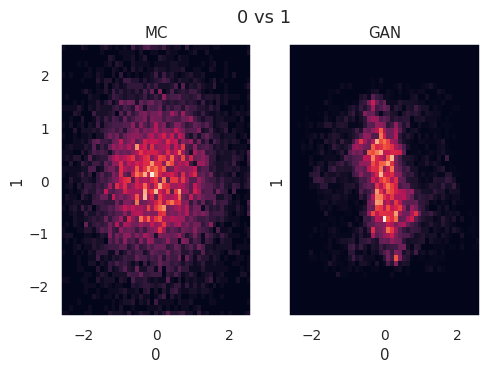

<Figure size 540x360 with 0 Axes>

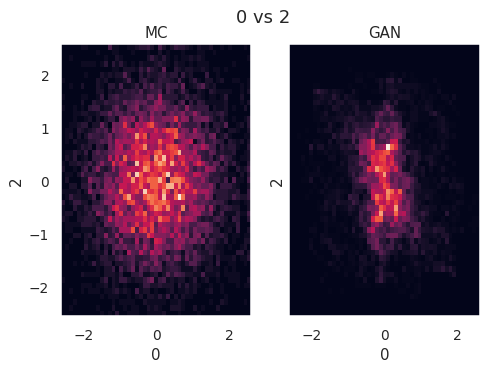

<Figure size 540x360 with 0 Axes>

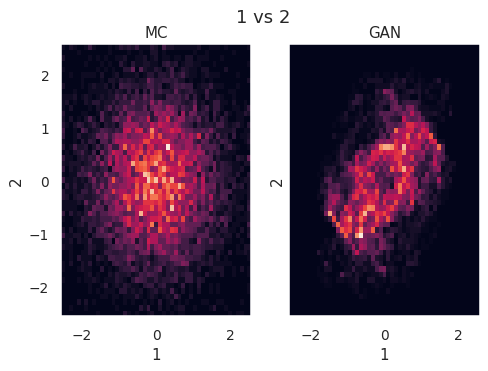

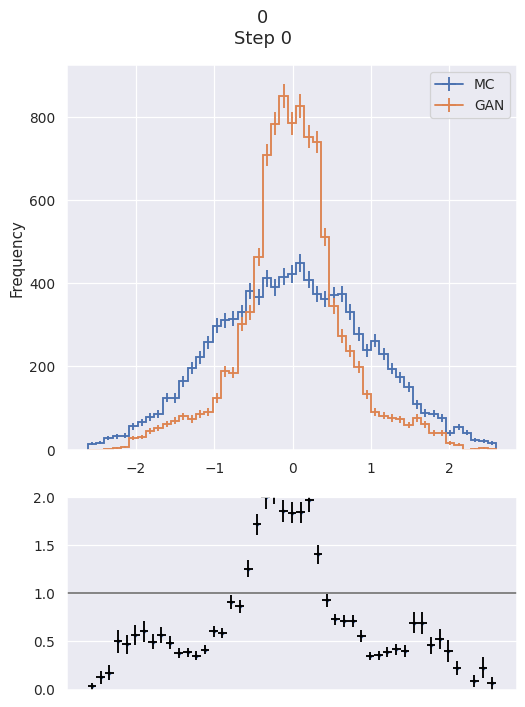

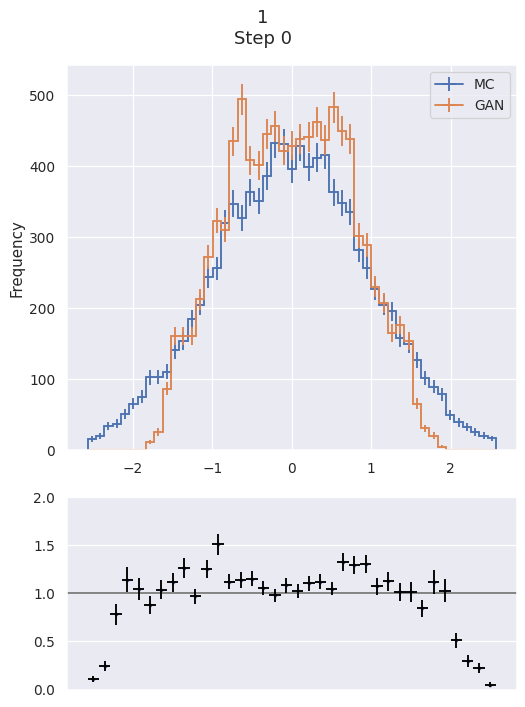

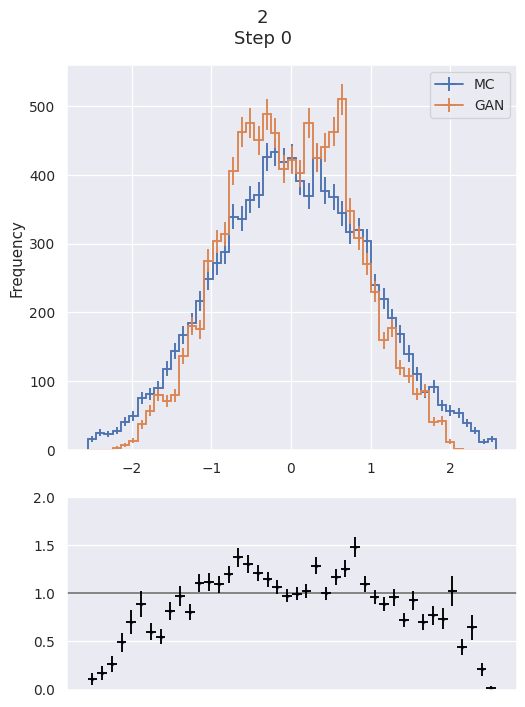

In [7]:

plt.rcParams["figure.dpi"] = 90
for v1, v2 in combinations(list(range(3)), 2):
    figure = xy_hist(
        sim=z.detach().cpu().numpy()[..., [v1, v2]],
        gen=x.detach().cpu().numpy()[..., [v1, v2]],
        v1name=v1,
        v2name=v2,
        title=f"{v1} vs {v2}",
    )
    plt.show(figure)

for v in range(3):
    ratioplot(
        sim=z.detach().cpu().numpy()[..., v],
        gen=x.detach().cpu().numpy()[..., v],
        title=str(v),
        step=0,
    )
